# 

In [1]:
import os
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from matplotlib import rc as mplrc
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import h, c, k
import specutils as spu
import re

import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings("ignore", category=FITSFixedWarning)

In [2]:
legends = 14
labels = 16
colorbars = 14
ticks = 14
lw = 3
ps = 25
colors = [
    "firebrick",
    "steelblue",
    "darkorange",
    "darkviolet",
    "cadetblue",
    "deeppink",
    "darkgreen",
    "magenta",
    "cyan",
]

# Class 4: Spectral Analysis

Spectroscopy is one of the most powerful tools in observational astronomy. A key aspect of spectroscopy is line emission and absorption, which are fundamental quantum processes. Elements and molecules all have different spectral imprints due to transitions between energy levels. Atoms have electronic transitions (i.e., an electron changes its energy level, $n$) whereas molecules can also have transitions due to changes in rotation and vibration modes ($J$ and $v$). Each of these has a specific energy that shows up as a a spectral imprint if that species is present and the conditions are right for that transition to take place. There are other types of discrete emission as well, such as Hydrogen's hyperfine (21 cm) emission due to the flipping of electron spins. All of these have their origin in quantum, and the description of lines such as the Balmer series was an important early success of quantum atomic theory.

The ability of spectroscopy to identify compositions has been historically important. One of the greatest examples is that of Cecilia Payne, who was the first to apply modern quantum spectroscopy to the solar spectrum in her 1925 thesis. Her work definitively showed that the Sun was primarily composed of Hydrogen, although this was met with strong rejections at the time.

Not only does spectroscopy allow us not only to learn about the composition of objects and areas that we observe, but also tells us about the conditions. For example, the Balmer series of Hydrogen is the set of transitions from the $n>2$ to $n=2$ levels. In order for this to happen, the electron needs to start at $n=3$ or greater. The $n=3$ level in Hydrogen is about 12.1 eV greater than the ground state energy (-13.6 eV). This is a significant amount of energy, so the presence of any significant amount of H $\alpha$ ($n=3\rightarrow 2$, $\lambda = 656.3$ nm) implies an energetic environment, perhaps a very hot one. H $\beta$ requires $n=4 \rightarrow 2$ ($\lambda = 486.1$ nm), which is even more energetic, and so on. The presence of strongly ionized elements can also imply an energetic environments. Hot, rarefied plasmas also have an increased probability of decaying via "forbidden lines." These decay routes typically occur at a much lower rate than normal transitions, especially when atomic collisions are frequent. However, when collisions are rare (e.g., in low density plasmas), atoms may have enough time to decay via forbidden routes before they are interrupted due to collisions. This is enhanced when the electrons are excited to high energy levels because this gives them more available forbidden routes and more time to do so. These lines, which are denoted by [...], can be important diagonistics in astrophysical environments, such as supernova remnants.

Conversely, the presence of complex molecules can imply "cold" environments, and they tend to have lines that have longer wavelengths, e.g., in the IR. Water, for example, starts to dissociate around 2,500 K. Observing significant amounts of water therefore can give a rough upper limit on the system's temperature (this is rough and statistical). Observing the signatures of water and other complex molecules has become of significant interest recently, particularly in the context of exoplanets and their atmospheres because of their implications for habitability. Telescopes like JWST are poised to revolutionize these types of studies given its unprecedented IR cabalities. When observing atmospheres, it is typical to look at absorption rather than emission because the background star's light is passing through the atmosphere, which absorbs the light according to its composition.

In [3]:
def get_hex_from_rgb(rgb: tuple) -> str:
    hex_color = '#{:02X}{:02X}{:02X}'.format(*rgb)
    return hex_color

# Define the Balmer series wavelengths in angstroms
balmer_wavelengths = {
    r"H $\alpha$": 6562.8,
    r"H $\beta$": 4861.3,
    r"H $\gamma$": 4340.5,
    r"H $\delta$": 4101.7,
    r"H $\epsilon$": 3970.1,
    r"H $\zeta$": 3889.1,
    r"H $\eta$": 3835.4
}

balmer_RGB = {
    r"H $\alpha$": (216, 48, 33),
    r"H $\beta$": (107, 221, 229),
    r"H $\gamma$": (38, 6, 232),
    r"H $\delta$": (104, 23, 195),
    r"H $\epsilon$": (100, 26, 132),
    r"H $\zeta$": (62, 17, 37),
    r"H $\eta$": (0, 0, 0), # black (we can't see)
}

balmer_hex = dict((line, get_hex_from_rgb(balmer_RGB[line])) for line in balmer_RGB)

balmer_lines = list(balmer_hex.keys())

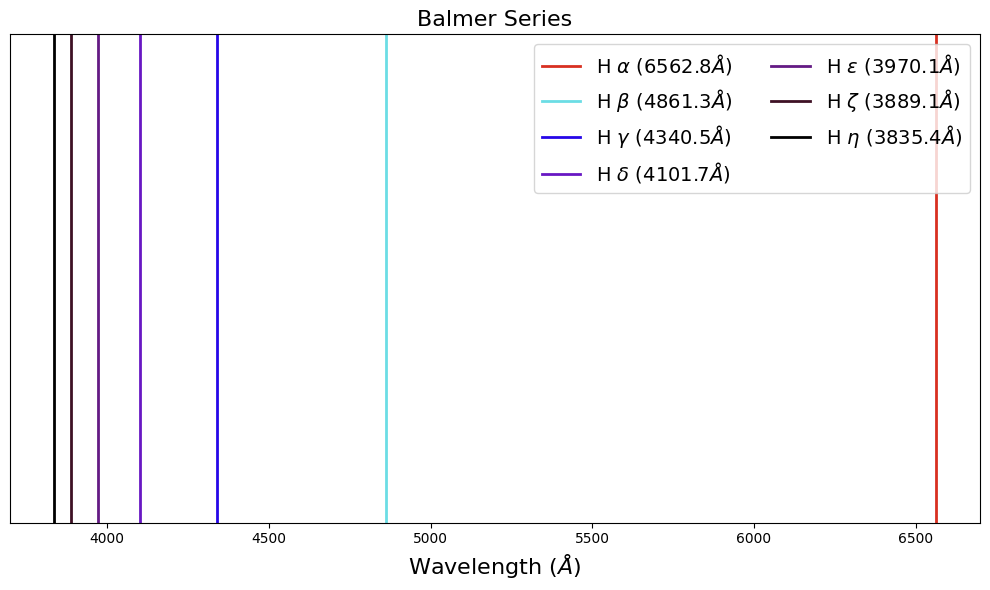

In [4]:
# Set up the plot
plt.figure(figsize=(10, 6))
plt.title("Balmer Series", fontsize=labels)
plt.xlabel(r"Wavelength (${\AA}$)", fontsize=labels)
plt.ylabel("")

# Plot each Balmer line
for i, line_ in enumerate(balmer_lines):
    plt.axvline(x=balmer_wavelengths[line_], 
                color=balmer_hex[line_], 
                linestyle='-', linewidth=2, 
                label=r"%s ($%.1f {\AA}$)" % (line_, balmer_wavelengths[line_]),
               )

plt.yticks([])
plt.legend(loc="best", ncols=2, fontsize=legends)
plt.tight_layout()
plt.show()

Blackbody radiation is another important concept in spectroscopy. A blackbody is an idealized object that is a perfect absorber and emitter. Obviously, such an object does not exist in nature, but there are many things, such as the Sun's atmosphere, that are close approximations. Blackbodies are particularly useful because their spectra have distinctive shapes descibed by an analytic formula, and the temperature of the object itself is directly related to the peak wavelength (Wien's displacement law) and the total emitted energy per time, i.e., luminosity (Stefan–Boltzmann law). 
$$\lambda_{peak} = \frac{b}{T}$$ where $b = 2.8978\times10^{−3}$ m K.
$$L_{\star} = 4\pi R^{2} \sigma T^{4}$$ where $\sigma=5.67037\times10^{−8}$ W m$^{−2}$ K$^{−4}$.

This can be particularly useful for simplifyling calculations and also locating stars on the H-R diagram. Since a main sequence star's luminosity is (roughly) determined by its spectral signature (of which temperature can be a proxy due to the blackbody approximation), finding the peak wavelength tells you what the star's luminsoity (due to SB Law) is. This is related to the star's mass and radius, which can be very important values. The luminosity formula just comes from the fact that the $\sigma T^{4}$ is luminosity per area (flux), so we just integrate over the entire spherical star to get the luminosity.

In [5]:
# Wien's constant in meters Kelvin
wien_constant = 2.897771955e-3  # m*K

def blackbody(wavelength: float, temperature: float) -> float:
    """
    Blackbody formula for a given wavelength and temperature
    """
    exponent = h * c / (wavelength * k * temperature)
    flux = (2 * h * c**2) / (wavelength**5 * (np.exp(exponent) - 1))
    
    return flux * 1e-9

In [6]:
# Get blackbody spectra over a range of wavelengths and temperatures
lambdas_nm = np.linspace(50, 3000, 1000)
lambdas_m = lambdas_nm * 1e-9
Ts = [3000, 4000, 5772, 7000, 8000, 10000,]

bb_spectra = dict((T, blackbody(lambdas_m, T)) for T in Ts)

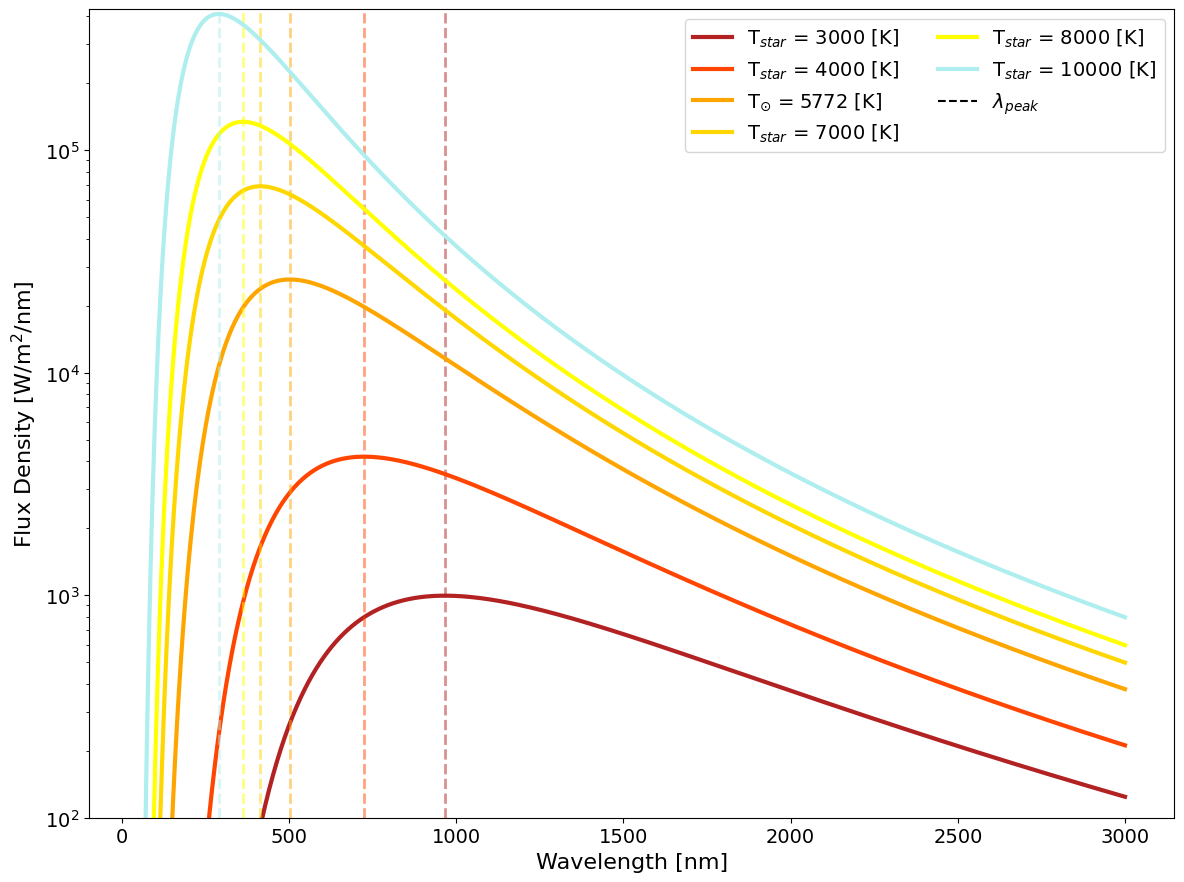

In [7]:
plt.figure(figsize=(14., 10.5))

star_colors = ["firebrick", "orangered", "orange", "gold", "yellow", "paleturquoise",]

for i, T in enumerate(Ts):
    # Get peak temperature with Wien's law
    peak_wavelength = wien_constant / T  # in meters
    peak_wavelength_nm = peak_wavelength * 1e9 # in nm 
    plt.plot(lambdas_nm, bb_spectra[T], lw=lw, c=star_colors[i], 
             label=r"T$_{star}$ = %i [K]" % (T) if T != 5772 else r"T$_{\odot}$ = %i [K]" % (T) 
            )
    plt.axvline(peak_wavelength_nm, lw=lw-1, c=star_colors[i], linestyle="--", alpha=0.5)
plt.plot([], [], ls="--", c="k", label=r"$\lambda_{peak}$")
plt.xlabel("Wavelength [nm]", fontsize=labels)
plt.ylabel(r"Flux Density [W/m$^{2}$/nm]", fontsize=labels)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.ylim(bottom=1e2)
plt.yscale("log")
plt.legend(loc="best", fontsize=legends, ncols=2)
plt.show()

# Load the data

We are using a MUSE data cube of the galaxy NGC 0360 observed in the visible to near IR. Downloaded from the [ESO Science archive](https://archive.eso.org/dataset/ADP.2023-11-02T13:39:58.831).

In [8]:
def parse_to_latex(string: str) -> str:
    """Takes in a string that might have **(..) and turns it into latex ^{...} using regular expressions
    then also replaces with angstrom symbol
    """
    return re.sub(r"\*\*\((-?\d+)\)", r"^{\1}", string).replace("angstrom", "{\AA}")

In [9]:
data_dir = "../Data/MUSE_NGC0360_cube/"
name = [x for x in os.listdir(data_dir) if ".fits" in x][0]
hdu = fits.open(f"{data_dir}{name}")
# Get a summary of the data
hdu.info()

Filename: ../Data/MUSE_NGC0360_cube/ADP.2023-11-02T13_39_58.831.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1702   ()      
  1  DATA          1 ImageHDU        44   (437, 439, 3681)   float32   
  2  STAT          1 ImageHDU        44   (437, 439, 3681)   float32   


In [10]:
# We can see that the second HDU is the one with the data
hdr = hdu[1].header
data = hdu[1].data
hdul = None # clear memory

In [11]:
# Let's just go ahead an change the units
hdr["BUNIT"] = parse_to_latex(hdr["BUNIT"])

In [12]:
# Notice that instead of CDELTi, the change in value for each axis is CDi_i
# Also, the wavelength center pixel is the first, not the middle like we frequently see
hdr

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  437 / length of data axis 1                          
NAXIS2  =                  439 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
OBJECT  = 'NGC0360 (DATA)'                                                      
CRPIX1  =     222.325530757466 / Pixel coordinate of reference point            
CRPIX2  =     222.034654928896 / Pixel coordinate of reference point            
CD1_1   = -5.55555555555556E-05 / Coordinate transformation matrix element      
CD1_2   =                   

# Basic analysis

In [13]:
def get_axis_values(hdr: fits.header.Header, axis=3, delta_label: str = "CDELT") -> np.ndarray:
    """Gets the values from a header axis
        This is completely general and allows you to 
        also use different delta values 
        For example, some use CD3_3 instead of CDELT3
    """
    
    # Generate pixel indices (1-based indexing)
    pixel_indices = np.arange(1, hdr[f"NAXIS{axis}"] + 1)
    
    # Calculate the values along the axis
    return hdr[f"CRVAL{axis}"] + (pixel_indices - hdr[f"CRPIX{axis}"]) * hdr[f"{delta_label}{axis}"]
    

## Visualization

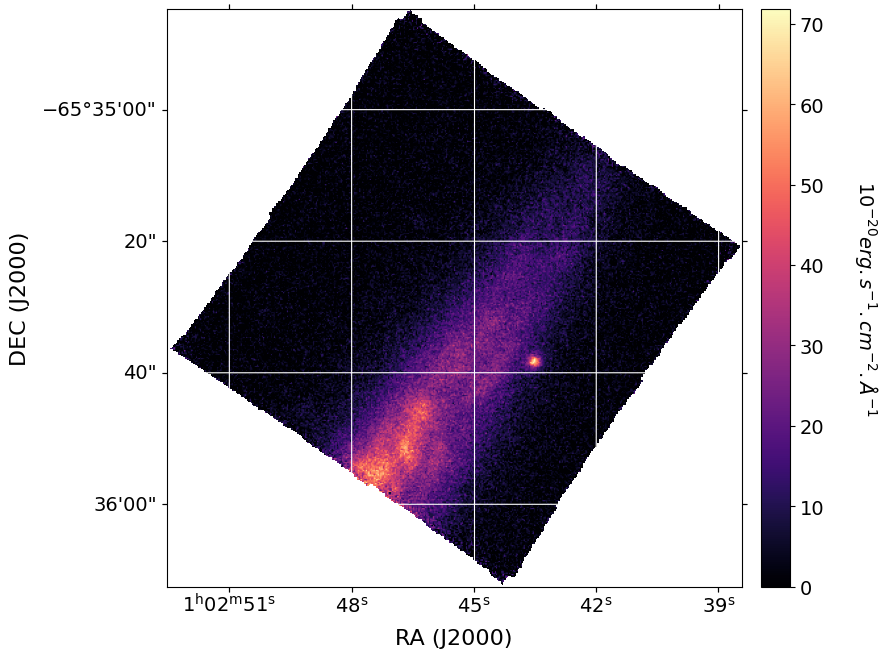

In [14]:
### Let's just grab a channel that shows the overall morphology
channel = 1825
mplrc("xtick", labelsize=ticks)
mplrc("ytick", labelsize=ticks)
mplrc('axes', labelsize=labels)

# We define the WCS system to get the sky coordinates
wcs = WCS(hdr, naxis=2,)

# We add the WCS as a projection
_, ax = plt.subplots(subplot_kw ={"projection": wcs}, 
                     figsize=(10., 7.5),
                    )
im = ax.imshow(data[channel], 
               origin="lower", 
               cmap="magma",
               vmin=0.,
              )

cbar = plt.colorbar(im, fraction=0.045, pad=0.025,)

# Now we can add the units to the colorbar
cbar.ax.set_ylabel(r"$%s$" % (hdr["BUNIT"]), 
                   rotation=270, 
                   fontsize=colorbars, 
                   labelpad=0.05,
                  )
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

# Add a grid if you want
ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel("RA (J2000)")
ax.coords[1].set_axislabel("DEC (J2000)")

plt.show()

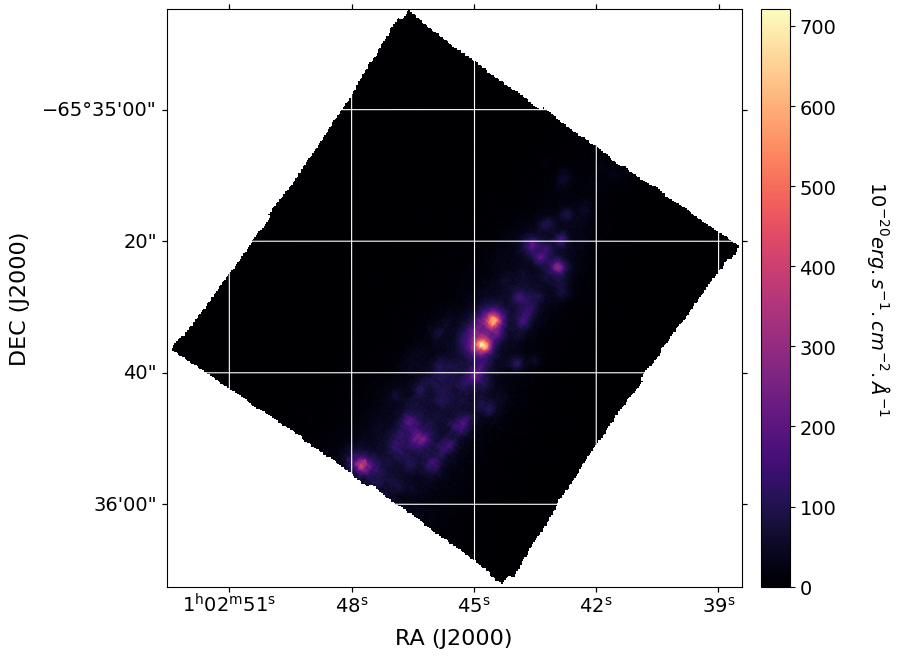

In [15]:
### And now the H alpha channel
channel = 1487
mplrc("xtick", labelsize=ticks)
mplrc("ytick", labelsize=ticks)
mplrc('axes', labelsize=labels)

# We define the WCS system to get the sky coordinates
wcs = WCS(hdr, naxis=2,)

# We add the WCS as a projection
_, ax = plt.subplots(subplot_kw ={"projection": wcs}, 
                     figsize=(10., 7.5),
                    )
im = ax.imshow(data[channel], 
               origin="lower", 
               cmap="magma",
               vmin=0.,
              )

cbar = plt.colorbar(im, fraction=0.045, pad=0.025,)

# Now we can add the units to the colorbar
cbar.ax.set_ylabel(r"$%s$" % (hdr["BUNIT"]), 
                   rotation=270, 
                   fontsize=colorbars, 
                   labelpad=0.05,
                  )
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

# Add a grid if you want
ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel("RA (J2000)")
ax.coords[1].set_axislabel("DEC (J2000)")

plt.show()

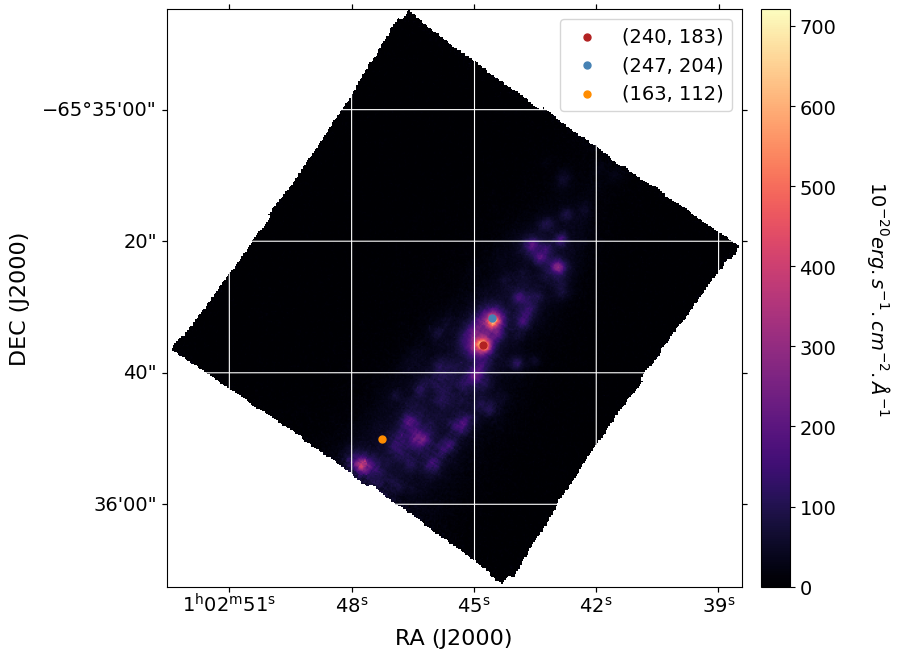

In [16]:
### We can see very interesting bright dots in the middle of the H alpha channel. 
### These are probably very energetic spots, so let's check them out
xys = [(240, 183), 
       (247, 204),
       (163, 112), # Normal pixel
     ]

### And now the H alpha channel
channel = 1487
mplrc("xtick", labelsize=ticks)
mplrc("ytick", labelsize=ticks)
mplrc('axes', labelsize=labels)

# We define the WCS system to get the sky coordinates
wcs = WCS(hdr, naxis=2,)

# We add the WCS as a projection
_, ax = plt.subplots(subplot_kw ={"projection": wcs}, 
                     figsize=(10., 7.5),
                    )
im = ax.imshow(data[channel], 
               origin="lower", 
               cmap="magma",
               vmin=0.,
              )

cbar = plt.colorbar(im, fraction=0.045, pad=0.025, alpha=0.2)

for i, xy in enumerate(xys):
    plt.scatter([xy[0]], [xy[1]], c=colors[i], label=f"{xy}", s=ps,)

# Now we can add the units to the colorbar
cbar.ax.set_ylabel(r"$%s$" % (hdr["BUNIT"]), 
                   rotation=270, 
                   fontsize=colorbars, 
                   labelpad=0.05,
                  )
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

# Add a grid if you want
ax.coords.grid(True, color="white", ls="solid")
ax.coords[0].set_axislabel("RA (J2000)")
ax.coords[1].set_axislabel("DEC (J2000)")

plt.legend(loc="upper right", fontsize=legends)


plt.show()

In [17]:
# Get the wavelengths from the header
axis = 3
wls = get_axis_values(hdr, axis=axis, delta_label=f"CD{axis}_")

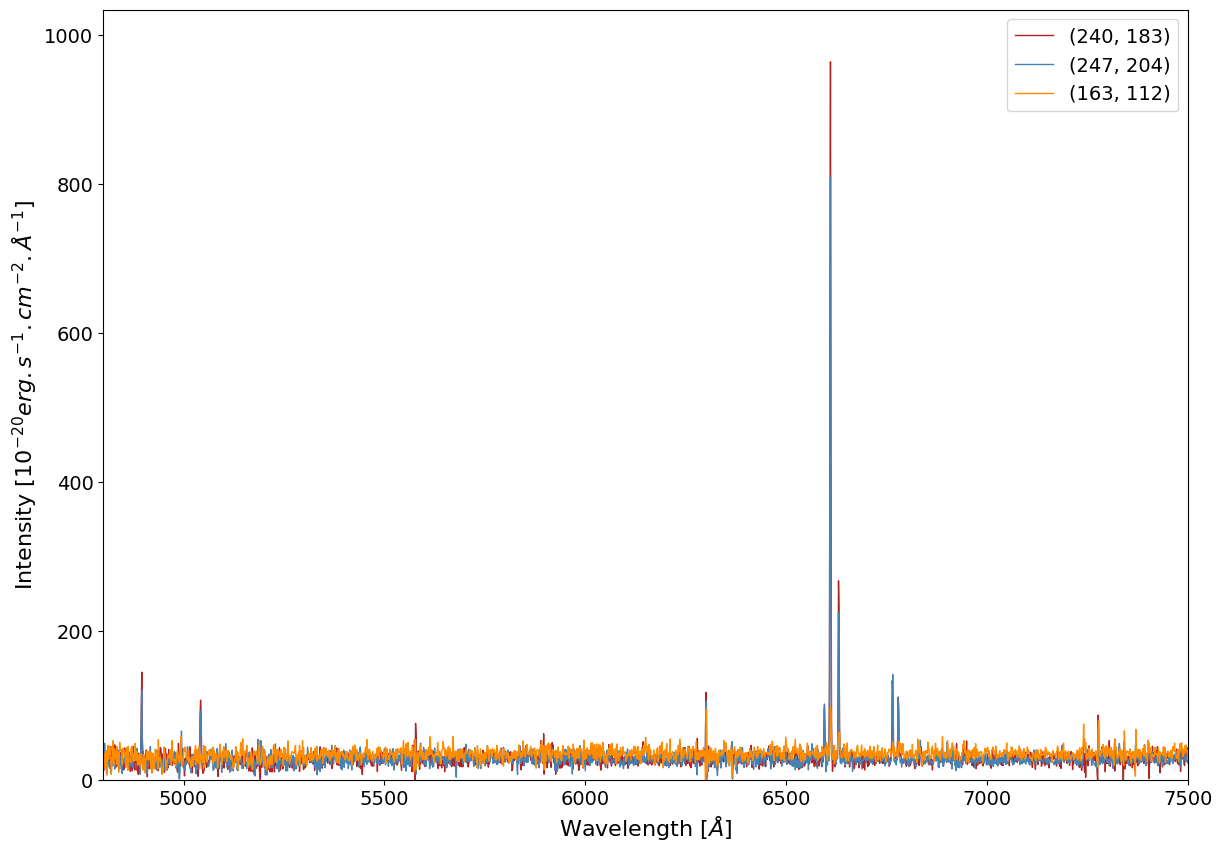

In [18]:
# Plot the spectra at each of the regions shown above
plt.figure(figsize=(14., 10.))

for i, xy in enumerate(xys):
    plt.plot(wls, data[:, xy[1], xy[0]], lw=1, c=colors[i], label=f"{xy}")

plt.xlabel(r"Wavelength [${\AA}]$", fontsize=labels)
plt.ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]), fontsize=labels)

plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.legend(loc="best", fontsize=legends)

plt.ylim(bottom=0)
plt.xlim(4800, 7500)
plt.show()

In [19]:
### Some of those lines (e.g., ~5600 A and 6400 A) are probably reduction artifcats.

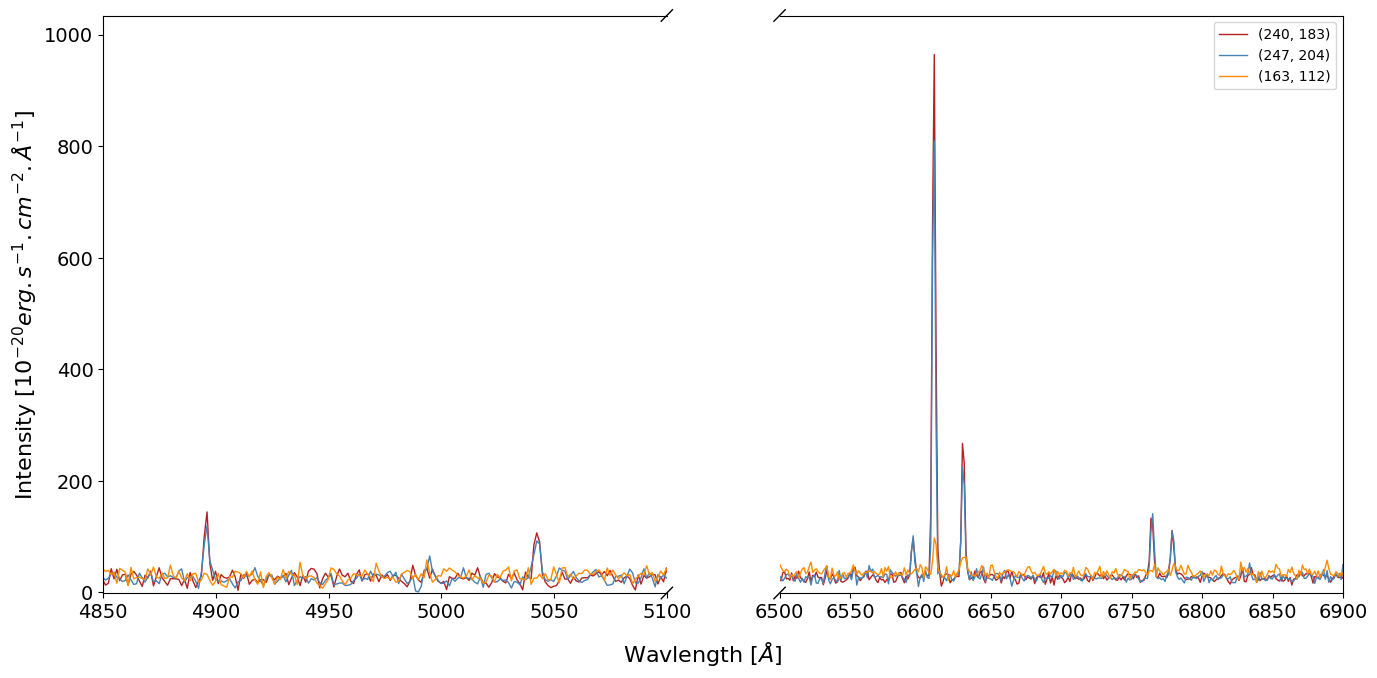

In [20]:
### Let's make a plot that focuses on the most important lines
## We'll do this with two subplots, one for each range that we care about
mplrc("xtick", labelsize=ticks)
mplrc("ytick", labelsize=ticks)
mplrc('axes', labelsize=labels)

fig, axs = plt.subplots(ncols=2, figsize=(16., 7.5))
for j, ax in enumerate(axs):
    for i, xy in enumerate(xys):
        ax.plot(wls, data[:, xy[1], xy[0]], lw=1, c=colors[i], label=f"{xy}" if j == 1 else None)
        
ax1, ax2 = axs[:]
ax1.set_ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]),)
ax1.set_xlim(4850, 5100)
ax2.legend(loc="best",)

ax2.set_ylabel(r"",)
ax2.set_xlim(6500, 6900)

ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

d = .01 
kwargs = dict(transform=ax1.transAxes, color='k', lw=1, clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)
fig.supxlabel(r"Wavlength [${\AA}$]", fontsize=labels)

plt.show()

So we can clearly see that there are some lines that are special in those bright knots. This implies that the knots have some qualitatively different properties from the rest of the galaxy. Let's look at the lines to try to get an idea.

## Lines
Let's try to identify those lines and use them to inform our analysis

In [21]:
def rest_to_obs(wl: float, z: float) -> float:
    """Use redshift and rest wavelength to get emitted wavelength"""
    return wl * (1. + z)
    
def obs_to_rest(wl: float, z: float) -> float:
    """Use redshift and observed wavelength to get rest wavelength"""
    return wl / (1. + z)
    
def get_z(wl_obs: float, wl_rest: float) -> float:
    """Use observed and rest wavelengths to get redshift"""
    return (wl_obs - wl_rest) / wl_rest

In [22]:
# Some typical emission line rest wavelengths in Angstroms
rest_wls = {"H_alpha": 6562.8,
             "H_beta": 4861.0,
             "[N II]": (6548.0, 6583.0),
             "[O III]": 5007.,
             "[S II]": (6716.0, 6731.0),
           }

[Redshift from here:](https://ned.ipac.caltech.edu/cgi-bin/objsearch?objname=NGC+360&extend=no&hconst=73&omegam=0.27&omegav=0.73&corr_z=1&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES)

In [23]:
z = 0.007693

In [24]:
# I found some unknown emission lines
unknown_obs = [4896., 5042., 6610., 6631., 6764., 6779.,]
unknown_rest = [obs_to_rest(line, z) for line in unknown_obs]

In [25]:
# Let's identify some lines
identified = {}
for rest, obs in zip(unknown_rest, unknown_obs):
    print(f"Rest wavelength for observed {obs} estimated to be {rest:.2f} Angstroms")
    closest = 1e3
    # Do a lazy method of finding the closest line
    for line in rest_wls:
        if type(rest_wls[line]) == float:
            diff = abs(rest_wls[line] - rest)
            if diff < closest:
                closest = diff
                best_guess = (line, rest_wls[line])
            continue
        for single_line in rest_wls[line]:
            diff = abs(single_line - rest)
            if diff < closest:
                closest = diff
                best_guess = (line, single_line)
    print(f"Best guess is {best_guess}\n")
    identified[(rest, obs)] = best_guess

Rest wavelength for observed 4896.0 estimated to be 4858.62 Angstroms
Best guess is ('H_beta', 4861.0)

Rest wavelength for observed 5042.0 estimated to be 5003.51 Angstroms
Best guess is ('[O III]', 5007.0)

Rest wavelength for observed 6610.0 estimated to be 6559.54 Angstroms
Best guess is ('H_alpha', 6562.8)

Rest wavelength for observed 6631.0 estimated to be 6580.38 Angstroms
Best guess is ('[N II]', 6583.0)

Rest wavelength for observed 6764.0 estimated to be 6712.36 Angstroms
Best guess is ('[S II]', 6716.0)

Rest wavelength for observed 6779.0 estimated to be 6727.25 Angstroms
Best guess is ('[S II]', 6731.0)



In [26]:
# Estimate the redshift using what we've found
# (I know this is somewhat circular)
# Let's use H alpha because that's really strong
H_alpha_obs = 6610.
z_est = get_z(H_alpha_obs, rest_wls["H_alpha"])
print(f"Estimated redshift if {z_est:.6}. Real is {z:.6}")
# Which is pretty close to the cited value

Estimated redshift if 0.00719205. Real is 0.007693


## Line Fitting

In [27]:
# # Let's grab the region immediately around H alpha
noise_lower = 6675.
noise_upper = 6725.
xy = (240, 183)
spec = data[:, xy[1], xy[0]].copy()
min_wl = 4800.
max_wl = 7200.
good = np.where((wls > min_wl) & (wls < max_wl))
spec = spec[good]
spec_wls = wls[good]
# subtract mean of a noisy region to bring the baseline to ~0
spec -= np.mean(spec[np.where((spec_wls > noise_lower) & (spec_wls < noise_upper))])


normal_xy = (163, 112)
normal_spec = data[:, normal_xy[1], normal_xy[0]].copy()
normal_spec = normal_spec[good]
normal_spec -= np.mean(normal_spec[np.where((spec_wls > noise_lower) & (spec_wls < noise_upper))])

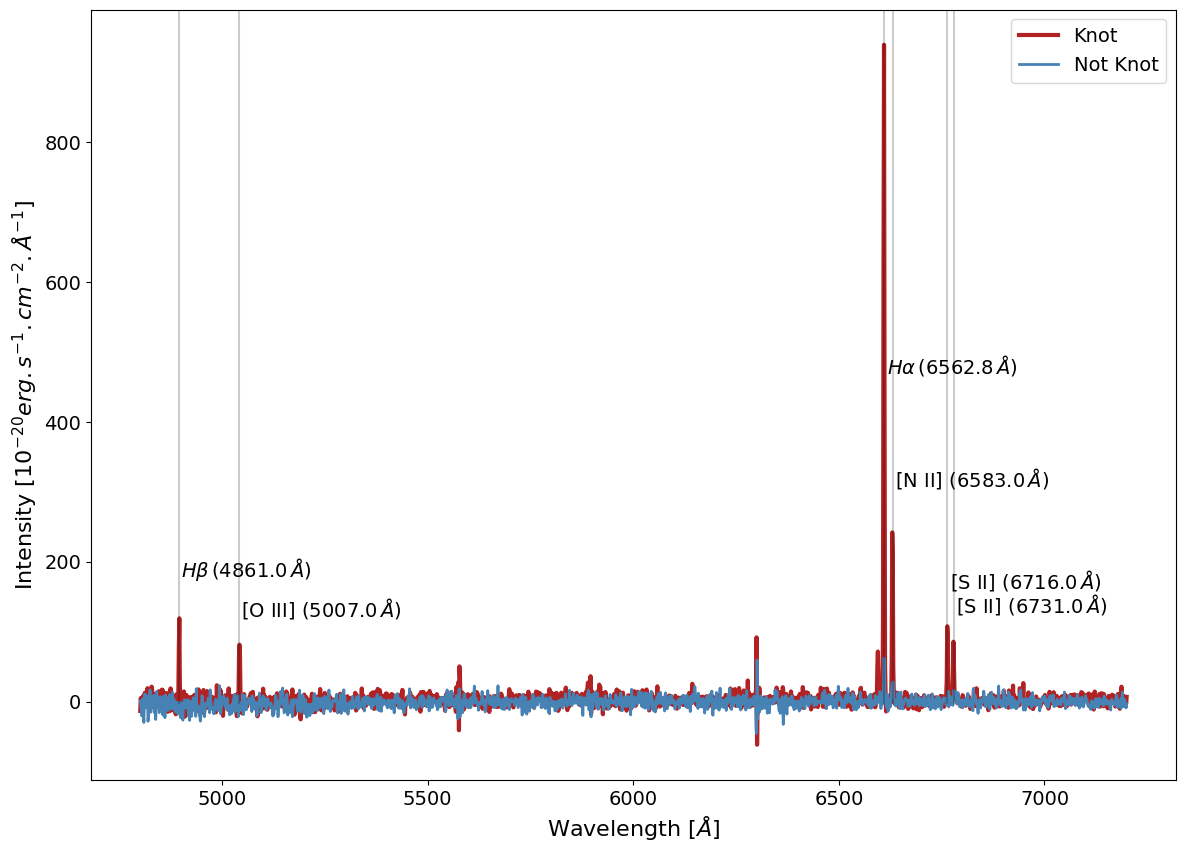

In [28]:
# Let's plot and label the lines
plt.figure(figsize=(14., 10.))

plt.plot(spec_wls, spec, lw=lw, c=colors[0], label=f"Knot")
plt.plot(spec_wls, normal_spec, lw=lw-1, c=colors[1], label=f"Not Knot",)

plt.xlabel(r"Wavelength [${\AA}]$", fontsize=labels,)
plt.ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]), fontsize=labels,)

plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.legend(loc="best", fontsize=legends)

# Let's label the lines that we can see
flux_locs = {}
flux_amp = {}
for rest, obs in zip(unknown_rest, unknown_obs):
    if obs > min_wl and obs < max_wl:
        flux_loc = np.argmin(np.abs(spec_wls - obs))
        flux_locs[(rest, obs)] = spec_wls[flux_loc]
        flux_value = spec[flux_loc]
        flux_amp[(rest, obs)] = flux_value
        plt.axvline(obs, c="k", ymin=0.1, alpha=0.2)
        if "alpha" not in identified[(rest, obs)][0] and "beta" not in identified[(rest, obs)][0]:
            plt.text(1.001*obs, 1.5*flux_value, 
                     r"%s ($%s\,{\AA})$" % (identified[(rest, obs)][0],
                                              identified[(rest, obs)][1],
                                             ),
                     c="k", fontsize=legends
                    )
        elif "alpha" in identified[(rest, obs)][0]:
            plt.text(1.001*obs, 0.5*flux_value, 
                     r"$H \alpha\, (%s\,{\AA})$" % (
                                              identified[(rest, obs)][1],
                                             ),
                     c="k", fontsize=legends
                    )
        else:
            plt.text(1.001*obs, 1.5*flux_value, 
                     r"$H \beta\, (%s\,{\AA})$" % (
                                              identified[(rest, obs)][1],
                                             ),
                     c="k", fontsize=legends
                    )
plt.show()

We see a lot more H alpha and highly ionized species as well as H beta shows up. This tells us that the knots are hotter/more energetic than the normal parts of the galaxy. This could indicate processes such as star formation.

In [29]:
from astropy.modeling import models
from specutils.fitting import fit_lines
from specutils.spectra import Spectrum1D

In [30]:
# we need to make units for the fitting to work
spec_unit = 1e-20 * u.erg / (u.s * u.cm**2 * u.AA)
wl_unit =  u.AA

In [31]:
# Make a spectrum using the proper units
spectrum = Spectrum1D(flux=spec * spec_unit, spectral_axis=spec_wls * wl_unit,)

Fitting line (4858.62261621347, 4896.0)
4896.05224609375 118.97868
Fitting line (5003.508012857091, 5042.0)
5042.30224609375 81.34056
Fitting line (6559.537478180358, 6610.0)
6609.80224609375 938.8638
Fitting line (6580.37715851951, 6631.0)
6631.05224609375 205.46652
Fitting line (6712.361800667465, 6764.0)
6763.55224609375 107.62784
Fitting line (6727.247286624002, 6779.0)
6778.55224609375 85.58467


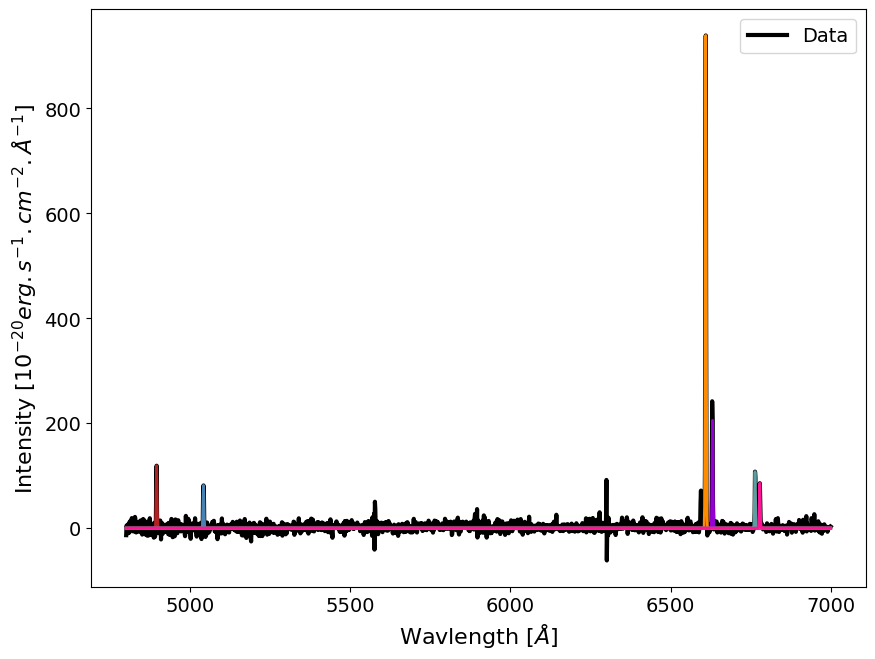

In [32]:
# We can fit them individually
# assume 1.5 A FWHM to start
fwhm = 1.5
# give a fit window width
window = 6.
plt.figure(figsize=(10., 7.5))
plt.plot(spec_wls, spec, c="k", lw=lw, label="Data")
all_fits = {}
i = 0
for line in flux_locs:
    print(f"Fitting line {line}")
    # We get the line center
    center = flux_locs[line]
    # Intensity at line
    amp = flux_amp[line]
    print(center, amp)
    # Assume a gaussian centered on the line
    g_init = models.Gaussian1D(amplitude=amp * spec_unit, 
                               mean=center * wl_unit, 
                               stddev=fwhm * wl_unit,
                              )
    # Fit the gaussian
    g_fit = fit_lines(spectrum, g_init, window=center * wl_unit + window * wl_unit)
                     
    all_fits[line] = g_fit(spec_wls * wl_unit)
    # Scale back up
    plt.plot(spec_wls, all_fits[line] * 1e20, c=colors[i], lw=lw-1,)
    i += 1

plt.xlabel(r"Wavlength [${\AA}$]", fontsize=labels)
plt.ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]), fontsize=labels)
plt.legend(loc="best", fontsize=legends)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.show()

In [33]:
# Or fit them together
fwhm = 1.5
# Let's make a Gaussian for each line
g_profiles = {}
# We have that one trailing (probable) H alpha at 6595
# This is a very interesting feature that is singificantly blueshifted relative to the strong H alpha
# The origin of this is unclear, but we will fit  it anyways just to improve our fit
all_profiles = [models.Gaussian1D(amplitude=spec[np.argmin(np.abs(spec_wls - 6595.))] * spec_unit,
                           mean=6595. * wl_unit,
                           stddev=1. * wl_unit
                          )]
# All other lines
line_order = list(flux_locs.keys())
for line in line_order:
    print(f"Fitting line {line}")
    # We get the line center
    center = flux_locs[line]
    # Intensity at line
    amp = flux_amp[line]
    # Assume a gaussian centered on the line
    g_profiles[line] = models.Gaussian1D(amplitude=amp * spec_unit, 
                               mean=center * wl_unit, 
                               stddev=fwhm * wl_unit,
                              )
all_profiles.extend([g_profiles[line] for line in line_order])
line_order.insert(0, (rest_wls["H_alpha"], 6595.))
g_fit = fit_lines(spectrum, np.sum(all_profiles))

Fitting line (4858.62261621347, 4896.0)
Fitting line (5003.508012857091, 5042.0)
Fitting line (6559.537478180358, 6610.0)
Fitting line (6580.37715851951, 6631.0)
Fitting line (6712.361800667465, 6764.0)
Fitting line (6727.247286624002, 6779.0)


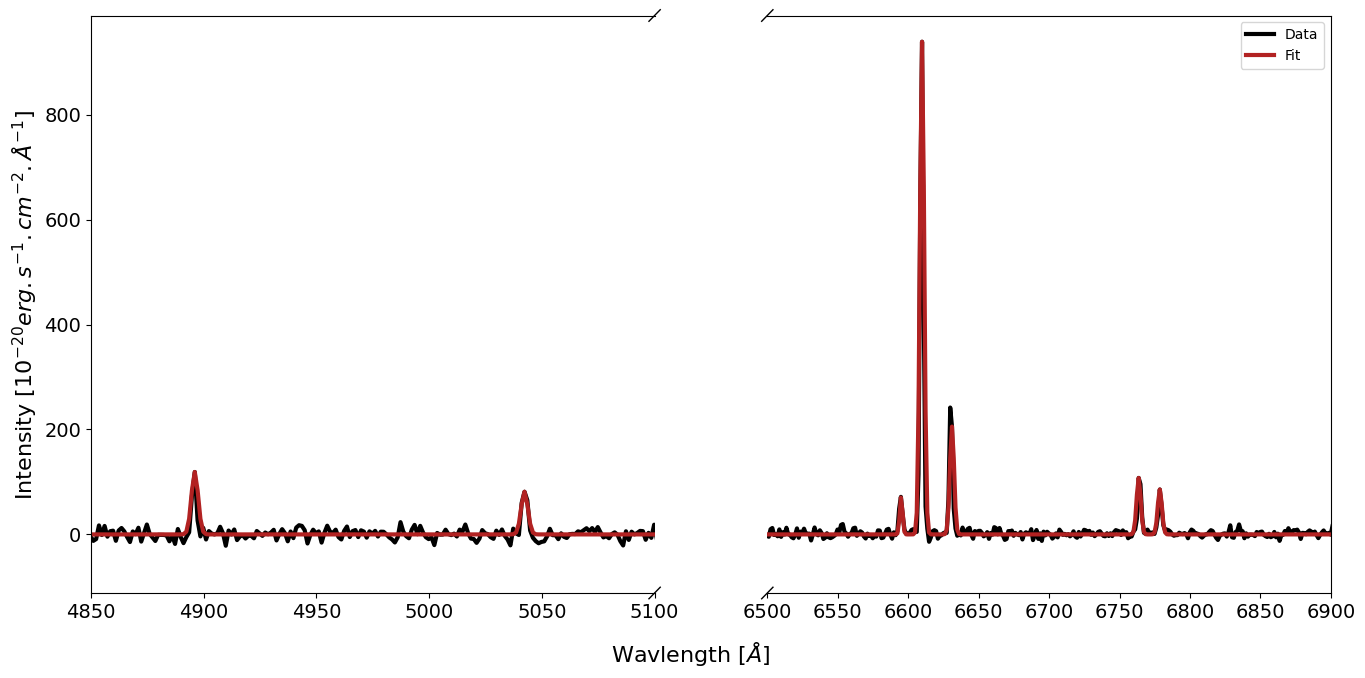

In [34]:
mplrc("xtick", labelsize=ticks)
mplrc("ytick", labelsize=ticks)
mplrc('axes', labelsize=labels)

fig, axs = plt.subplots(ncols=2, figsize=(16., 7.5))
for j, ax in enumerate(axs):
    ax.plot(spec_wls, spec, lw=lw, c="k", label="Data" if j == 1 else None)
    ax.plot(spec_wls, g_fit(spec_wls * wl_unit) * 1e20, lw=lw, c=colors[0], label="Fit" if j == 1 else None)
    
ax1, ax2 = axs[:]
ax1.set_ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]),)
ax1.set_xlim(4850, 5100)
ax2.legend(loc="best",)

ax2.set_ylabel(r"",)
ax2.set_xlim(6500, 6900)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

d = .01 
kwargs = dict(transform=ax1.transAxes, color='k', lw=1, clip_on=False)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)
fig.supxlabel(r"Wavlength [${\AA}$]", fontsize=labels)

plt.show()

In [35]:
for line in identified:
    if identified[line][0] == "H_alpha":
        h_alpha_amp = float(flux_amp[line])
        break

In [36]:
### These lines show typical emission lines from energetic regions, e.g., star forming locations.
### So it seems like something interesting is going on in the knots
### Let's quantity this with line ratios to H alpha
line_ratios = {}
for i, line in enumerate(g_fit):
    ratio = float(line.amplitude.value) * 1e20 / h_alpha_amp
    if line_order[i] in identified:
        name = identified[line_order[i]][0]
        original_name = name
        j = 1
        while name in line_ratios:
            name = f"{original_name} ({j})"
            j += 1
    else:
        name = "trailing"
    line_ratios[name] = ratio
line_ratios

{'trailing': 0.07620870395305163,
 'H_beta': 0.12672624861334525,
 '[O III]': 0.08663723487135641,
 'H_alpha': 0.9999999999999999,
 '[N II]': 0.21884593791427367,
 '[S II]': 0.1146362673985187,
 '[S II] (1)': 0.09115770977427107}

In [37]:
### Let's do the same for the not knot
### For simplicity, we'll only do [N II] because we can't even see [S II], [O III], or H beta
noise_lower = 6675
noise_upper = 6725
normal_xy = (163, 112)
norm_spec = data[:, normal_xy[1], normal_xy[0]].copy()
norm_spec = norm_spec[good]
norm_wls = wls[good]
norm_spec -= np.mean(norm_spec[np.where((norm_wls > noise_lower) & (norm_wls < noise_upper))])

norm_hA_index = np.argmax(norm_spec)
norm_hA_wl = norm_wls[norm_hA_index]
norm_hA_amp = np.max(norm_spec)

for line in identified:
    if identified[line][0] == "[N II]":
        nII_wl = line[1]
        nII_amp = norm_spec[np.argmin(np.abs(nII_wl - norm_wls))]
        break

In [38]:
# Make a spectrum using the proper units
norm_spectrum = Spectrum1D(flux=normal_spec * spec_unit, spectral_axis=spec_wls * wl_unit)

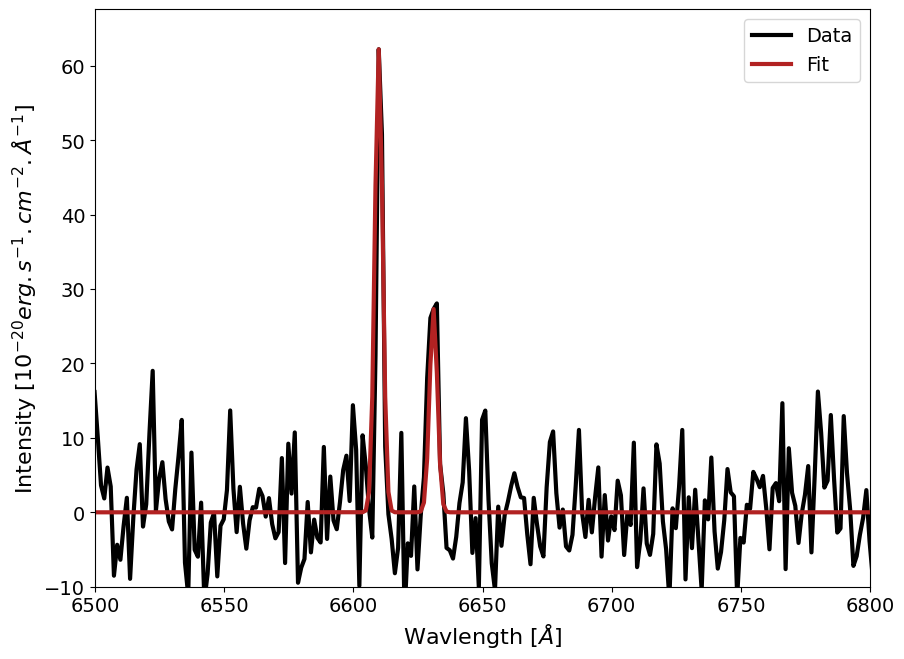

In [39]:
fhwh = 2.
# Make a model for H alpha
g_Ha = models.Gaussian1D(amplitude=norm_hA_amp * spec_unit, 
                               mean=norm_hA_wl * wl_unit, 
                               stddev=fwhm * wl_unit,
                              )
# Make a model for [N II]
g_nII = models.Gaussian1D(amplitude=nII_amp * spec_unit, 
                               mean=nII_wl * wl_unit, 
                               stddev=fwhm * wl_unit,
                              )
g_norm_fit = fit_lines(spectrum, g_Ha + g_nII)

plt.figure(figsize=(10., 7.5))

plt.plot(spec_wls, norm_spec, lw=lw, c="k", label="Data")
plt.plot(spec_wls, g_norm_fit(spec_wls * wl_unit) * 1e20, lw=lw, c=colors[0], label="Fit")
plt.legend(loc="best", fontsize=legends)

plt.xlabel(r"Wavlength [${\AA}$]", fontsize=labels)
plt.ylabel(r"Intensity [$%s$]" % (hdr["BUNIT"]), fontsize=labels)
plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)
plt.xlim(6500, 6800)
plt.ylim(bottom=-10)

plt.show()

In [40]:
print(f"[N II] / Halpha off knot ratio = {g_norm_fit[1].amplitude.value * 1e20 / norm_hA_amp :.4}")
print(f"[N II] / Halpha on knot ratio = {line_ratios['[N II]'] :.4}")

[N II] / Halpha off knot ratio = 0.4392
[N II] / Halpha on knot ratio = 0.2188


# Bonus: Reading in .fits tables
This is a NIRSpec (JWST) observation of the atmosphere of exoplanet WASP 77A (downloaded from [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)). It is our first example of a fits table, which will sometimes be used when dealing with spectra. They are somewhat different than other .fits files, and usually can't be viewed in a fits viewer. We aren't going to work with the data, but this is a basic way to read it in. The data consists of over 2,000 different spectra of the same target, so there are *tons* of HDUs.

In [41]:
# Change for yourself
spec_dir = "../Data/JWST_WASP77A/JWST/jw01274-o010_t004_nirspec_f290lp-g395h-sub2048/"
name = [x for x in os.listdir(spec_dir) if ".fits" in x][0]
filename = f"{spec_dir}{name}"

In [42]:
all_flux = {}
all_wl = {}
with fits.open(filename) as hdul:
    # They're noisy, so we are just going to stack a bunch on top of each other
    for hdu_index in range(2, 12):
        spec_data = hdul[hdu_index].data
        flux = spec_data['FLUX']
        wl = spec_data['WAVELENGTH']
    
        # Filter out NaN and non-positive values
        valid = ~np.isnan(flux) & (flux > 0)
        all_wl[hdu_index] = wl[valid]
        all_flux[hdu_index] = flux[valid]

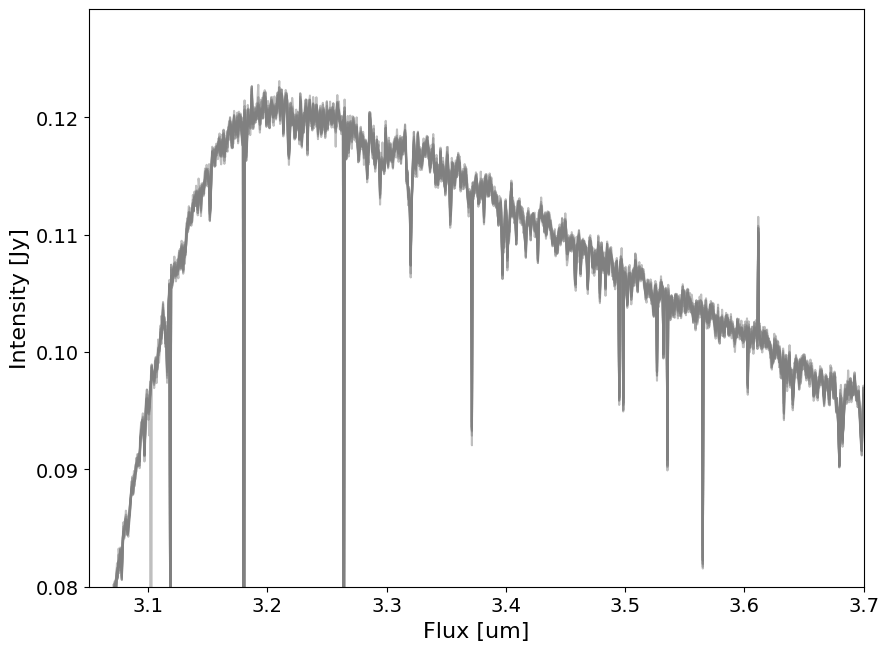

In [43]:
plt.figure(figsize=(10., 7.5))
for hdu_index in all_wl:
    plt.plot(all_wl[hdu_index], all_flux[hdu_index], c="gray", alpha=0.5)

plt.xlabel(f"Flux [{hdul[2].header['TUNIT1']}]", fontsize=labels) 
plt.ylabel(f"Intensity [{hdul[2].header['TUNIT2']}]", fontsize=labels) 

plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.xlim(left=3.05, right=3.7)
plt.ylim(bottom=0.08)

plt.show()